In [2]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import cirq 
import cirq_google
import qsimcirq

from circuits import *
from utils import *

import matplotlib.pyplot as plt

In [3]:
processor_id = "willow_pink"
device = cirq_google.engine.create_device_from_processor_id(processor_id)
gateset = device.metadata.compilation_target_gatesets[0]
connectivity_graph = device.metadata.nx_graph

noise_props = cirq_google.engine.load_device_noise_properties(processor_id)
noise_model = cirq_google.NoiseModelFromGoogleNoiseProperties(noise_props)
sim = qsimcirq.QSimSimulator(noise=noise_model)
cal = cirq_google.engine.load_median_device_calibration(processor_id)
sim_processor = cirq_google.engine.SimulatedLocalProcessor(
    processor_id=processor_id, sampler=sim, device=device, calibrations={cal.timestamp // 1000: cal})
sim_engine = cirq_google.engine.SimulatedLocalEngine([sim_processor])

In [4]:
A = [cirq.GridQubit(5,9), cirq.GridQubit(6,9)]
B = [cirq.GridQubit(5,10), cirq.GridQubit(6,10)]
C = [cirq.GridQubit(5,11), cirq.GridQubit(6,11)]

# 1) Prepare conjugate fiducial in A and fiducial in B. 
# 2) Transform them into the appropriate ancilla initial state.
# 3) Swap B and C. So now A and C are ancillas, and B is the system, in between them.
# 4) Prepare the system in B: use the fiducial itself!
# 5) Apply the Arthurs-Kelly interaction.
# 6) Measure the ancillas.
circuit = cirq.Circuit((d4_fiducial(A, conjugate=True),\
                        d4_fiducial(B),\
                        AP(A,B),\
                        SWAP(B[0], C[0]),\
                        SWAP(B[1], C[1]),\
                        d4_fiducial(B),\
                        AK(B, A, C)),\
                        cirq.measure(*(A+C), key="result"))
optimized_circuit = cirq.optimize_for_target_gateset(cirq.RouteCQC(connectivity_graph)(circuit),\
                                                     context=cirq.TransformerContext(deep=True), gateset=gateset)
device.validate_circuit(optimized_circuit)
print(optimized_circuit)

(1, 7): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
# Realistic simulation
N = 50000
samples = sim_engine.get_sampler(processor_id).run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
freqs =  np.array([v for k, v in sorted(counts.items())])/N
freqs

array([0.154, 0.056, 0.065, 0.079, 0.071, 0.055, 0.055, 0.043, 0.063,
       0.046, 0.049, 0.04 , 0.062, 0.066, 0.04 , 0.058])

In [ ]:
# Exact simulation 
s = cirq.Simulator()
samples = s.run(circuit, repetitions=N)
counts = samples.histogram(key="result")
freqs =  np.array([v for k, v in sorted(counts.items())])/N
freqs

array([0.248, 0.05 , 0.05 , 0.051, 0.049, 0.05 , 0.05 , 0.05 , 0.05 ,
       0.05 , 0.051, 0.05 , 0.05 , 0.052, 0.05 , 0.05 ])

In [ ]:
# Direct calculation
d = 4
phi = d4_fiducial_ket()
Pi = np.outer(phi, phi.conj())
E = wh_povm(phi)
p = np.array([(e@Pi).trace() for e in E]).real; p

array([0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05])

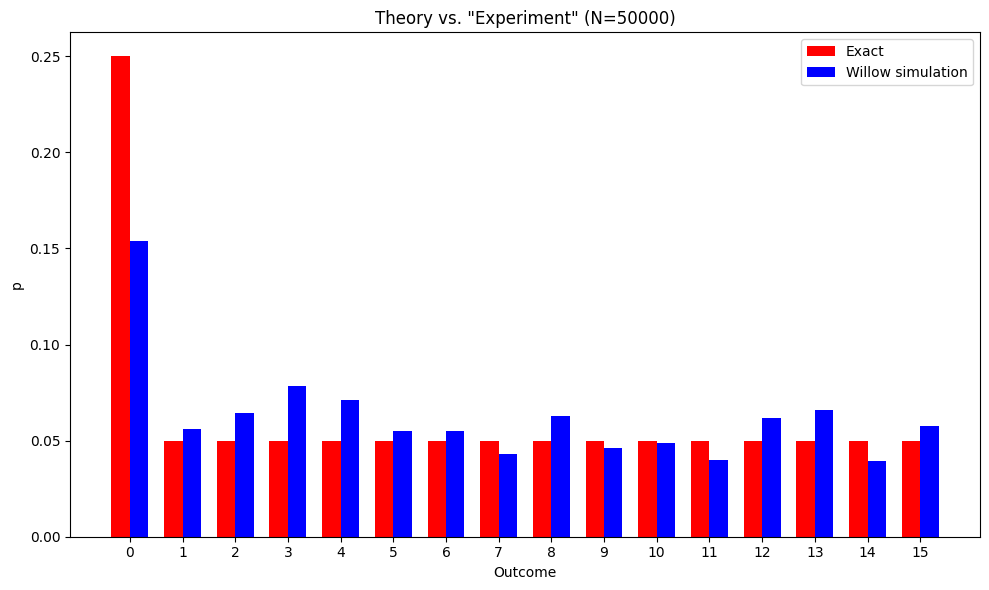

In [27]:
x_pos = np.arange(2**4) 
bar_width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x_pos - bar_width/2, p, width=bar_width, label='Exact', color='red')
plt.bar(x_pos + bar_width/2, freqs, width=bar_width, label='Willow simulation', color='blue')
plt.ylabel('p')
plt.xlabel('Outcome')
plt.title('Theory vs. "Experiment" (N=%d)' % N)
plt.xticks(x_pos)
plt.legend()
plt.tight_layout()

In [5]:
get_gate_counts(circuit)

--- Gate Counts (by type) ---
Ry: 15
_PauliX: 6
CXPowGate: 18
ZPowGate: 9
HPowGate: 17
SwapPowGate: 9
CZPowGate: 25
MeasurementGate: 1


In [43]:
get_gate_counts(optimized_circuit)

--- Gate Counts (by type) ---
PhasedXZGate: 124
CZPowGate: 127
PhasedXPowGate: 159
ZPowGate: 9
MeasurementGate: 1
